In [78]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import warnings
import math
import numpy as np
import seaborn as sns
from glob import glob
from scipy.optimize import curve_fit
import logging

In [3]:
# Load data

measurement_dirs = []
# measurement_dirs += glob(f"data/2024-06-17_21*/*/*/*")
# measurement_dirs += glob(f"data/2024-06-18*/*/*/*")
measurement_dirs += glob(f"data/2024-06-21*/*/*/*")
measurement_dirs += glob(f"data/2024-06-22*/*/*/*")
# measurement_dirs += glob(f"data_scale/*/*")
# measurement_dirs += glob(f"data_scale_rampup/*/*")

measurement_dirs = sorted(measurement_dirs)
display(measurement_dirs)

['data/2024-06-21_18-22-58/exp_scale_fixed/baseline_vanilla_full/0',
 'data/2024-06-21_18-22-58/exp_scale_fixed/dbopt_feature_db-optimization_full/0',
 'data/2024-06-21_18-22-58/exp_scale_fixed/jvm_jvm-impoove_full/0',
 'data/2024-06-21_18-22-58/exp_scale_fixed/norec_feature_norecommendations_full/0',
 'data/2024-06-21_18-22-58/exp_scale_fixed/obs_feature_object-storage_full/0',
 'data/2024-06-21_18-22-58/exp_scale_pausing/baseline_vanilla_full/0',
 'data/2024-06-21_18-22-58/exp_scale_pausing/dbopt_feature_db-optimization_full/0',
 'data/2024-06-21_18-22-58/exp_scale_pausing/jvm_jvm-impoove_full/0',
 'data/2024-06-21_18-22-58/exp_scale_pausing/norec_feature_norecommendations_full/0',
 'data/2024-06-21_18-22-58/exp_scale_pausing/obs_feature_object-storage_full/0',
 'data/2024-06-21_18-22-58/exp_scale_rampup/baseline_vanilla_full/0',
 'data/2024-06-21_18-22-58/exp_scale_rampup/dbopt_feature_db-optimization_full/0',
 'data/2024-06-21_18-22-58/exp_scale_rampup/jvm_jvm-impoove_full/0',
 'da

In [79]:
node_models = {
    "sm-gpu":[4.19542760e+01, 1.49493895e+01, 8.49503947e-05],
    "ise-knode6":[4.28145431e+01, 8.30311457e-01, 2.13227901e-04],
}

def energy_func(X, a, b, c):
    return a + b * X[:, 0] + c * X[:, 1]

def model_energy_funct(df:pd.DataFrame):
    for instance in node_models:
        df.loc[df["instance"]==instance,"wattage_estimation"] = energy_func(df[df["instance"]==instance][['cpu_usage', 'memory_usage']].values,*node_models[instance])
    return df

from scipy.stats import zscore
def measurment_processor(df:pd.DataFrame, z_score_threshold: float = 4, drop_unknown_instance:bool=True):
    data_errors = 0
    data_size = len(df)

    #print(f'{len(df[df["collection_time"] == "0"])} timeoffs')
    data_errors += len(df[df["collection_time"] == "0"])

    #time alignment - map data time to experiment time to get a relative score
    df = df.drop(df[df["collection_time"] == "0"].index)
    df["collection_time"] = pd.to_datetime(df["collection_time"],format="mixed")
    df["run_time"] = (df["collection_time"] - df["collection_time"].min())
    df["run_time"] = df["run_time"].apply(lambda x:int(x.total_seconds()))
    
    
    #quality control (check if we have unknown data points (thats and issue), z-scroe > threshold) and remove
    instance_issues = df[df["instance"] == "unknown"].index
    data_errors += len(instance_issues)
    
    if drop_unknown_instance:
        #print(f"dropped {len(instance_issues)} unknowns")
        df = df.drop(instance_issues)

    #calculate z-scores
    common_keys = ["wattage_kepler","wattage_scaph","cpu_usage","memory_usage","network_usage"]
    for key in common_keys:
        df[f"{key}_zscore"]  = zscore(df[key])


    for key in common_keys:
        outliers = df[df[f"{key}_zscore"].abs() > z_score_threshold].index
        #print(f"{len(outliers)} zScore")
        data_errors += len(outliers)
        df = df.drop(outliers)

    df = model_energy_funct(df)

    return df, (data_errors/data_size)

def exp_file_to_df(file:str, prefix: str) -> pd.DataFrame:
    (pr_time,pr_scale, pr_branch, pr_run, pr_name) = "/".join(file.split("/")[-5:]).split("/")
    pod_df = pd.read_csv(file)
    pod_df["exp_workload"] = pr_scale
    pod_df["exp_branch"] = pr_branch
    pod_df["exp_run_i"] = pr_run
    pod_df["exp_time"] = pr_time
    
    run_name = pr_name.replace(prefix, "").replace(".csv", "")
    scaler = pr_branch.split("_")[-1]

    pod_df["exp_run"] = run_name
    pod_df["exp_scaler"] = scaler

    pod_df["run"] = "_".join([pr_branch, pr_scale, pr_run])

    return pod_df

def measurement_file_to_df(file:str, df:pd.DataFrame, quality_control=True, quality_warning=0.1, quality_error=0.25):
    # no risk, no fun
    if quality_control:
        df, error_rate = measurment_processor(df)
        if error_rate > quality_error:
            raise ValueError(f"{file} contains {int(error_rate*100)}% fauly measurments (z-score, unknowns, 0-time...)")
        if error_rate > quality_warning:
            logging.warning(f"{file} contains quality issues, droped: {int(error_rate*100)}% of measurments")
    else:
         df, _ = measurment_processor(df,z_score_threshold=10, drop_unknown_instance=False)
    
    return df


def get_df_for_prefix(prefix, measurement_dirs, quality_control=True, quality_threshold=0.25, fail_on_quality_error=True):
    pod_files = np.concatenate([glob(f"{d}/{prefix}*") for d in measurement_dirs])
    
    def loader(f):
        try:
            return measurement_file_to_df(f,exp_file_to_df(f, prefix), quality_control=quality_control, quality_error=quality_threshold)
        except ValueError as e:
            if fail_on_quality_error:
                raise e
            else:
                logging.error(f"{f} contains >= {int(quality_threshold*100)}% fauly measurments (z-score, unknowns, 0-time...), droping the measurment")
                return None
        
    all_pods = pd.concat([loader(pf) for pf in pod_files])
    return all_pods

def get_stats_df_for_prefix(prefix:str, measurement_dirs:str):
    stat_files = np.concatenate([glob(f"{d}/{prefix}*") for d in measurement_dirs])
    all_stats = pd.concat([exp_file_to_df(pf,prefix) for pf in stat_files])
    #renamte colums to lowercase and without spaces
    all_stats.columns = list(map(lambda x:x.lower().replace(" ","_"),all_stats.columns.values))
    return all_stats[all_stats["name"]!= "Aggregated"]


In [80]:
all_nodes = get_df_for_prefix("measurements_node_", measurement_dirs)
all_nodes

,instance,observation_time,collection_time,cpu_usage,memory_usage,network_usage,wattage,num_processes,wattage_kepler,wattage_scaph,...,exp_run,exp_scaler,run,run_time,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,wattage_estimation
0,sm-gpu,2024-06-21 20:59:55,2024-06-21 20:59:55,0.414763,0.135156,0.071736,47,12,0.478200,16.930880,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,-0.065215,1.440066,0.219216,-0.837928,-0.320866,48.154748
1,ise-kmaster,2024-06-21 20:59:55,2024-06-21 20:59:55,0.219377,0.241342,0.337807,0,10,0.000000,0.000000,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,-0.632276,-0.705155,-0.225942,0.788169,-0.236853,NaN
2,ise-knode2,2024-06-21 20:59:55,2024-06-21 20:59:55,0.078333,0.215238,0.009853,0,5,0.000000,0.000000,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,-0.632276,-0.705155,-0.547290,0.388414,-0.340406,NaN
4,ise-knode3,2024-06-21 20:59:55,2024-06-21 20:59:55,0.036667,0.129553,0.012723,0,5,0.000000,0.000000,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,-0.632276,-0.705155,-0.642222,-0.923723,-0.339499,NaN
5,ise-knode6,2024-06-21 20:59:55,2024-06-21 20:59:55,0.207667,0.094686,0.489821,43,17,2.140719,15.343599,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,1.906240,1.238950,-0.252623,-1.457667,-0.188853,42.986991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,ise-knode1,2024-06-22 14:47:30,2024-06-22 14:47:30,0.289000,0.190135,0.694416,0,15,0.087300,0.108896,...,22_06_2024_14_41,full,obs_feature_object-storage_full_exp_scale_shap...,343,-0.512882,-0.693736,0.220497,0.337407,0.629122,NaN
206,ise-knode2,2024-06-22 14:47:30,2024-06-22 14:47:30,0.052000,0.217170,0.158973,0,5,0.000000,0.000000,...,22_06_2024_14_41,full,obs_feature_object-storage_full_exp_scale_shap...,343,-0.621765,-0.707722,-0.942263,0.869496,-0.986351,NaN
207,sm-gpu,2024-06-22 14:47:30,2024-06-22 14:47:30,0.234000,0.178092,0.298472,46,13,0.273333,15.368711,...,22_06_2024_14_41,full,obs_feature_object-storage_full_exp_scale_shap...,343,-0.280856,1.266119,-0.049342,0.100381,-0.565473,45.452448
208,ise-kmaster,2024-06-22 14:47:30,2024-06-22 14:47:30,0.214667,0.243522,0.342906,0,10,0.000000,0.000000,...,22_06_2024_14_41,full,obs_feature_object-storage_full_exp_scale_shap...,343,-0.621765,-0.707722,-0.144194,1.388125,-0.431412,NaN


In [82]:
# get all pod measurements
logging.getLogger().setLevel(logging.ERROR)
all_pods = get_df_for_prefix("measurements_pod_", measurement_dirs, fail_on_quality_error=False)
all_pods["instance"].unique()

ERROR:root:data/2024-06-21_18-22-58/exp_scale_pausing/baseline_vanilla_full/0/measurements_pod_21_06_2024_20_52.csv contains >= 25% fauly measurments (z-score, unknowns, 0-time...), droping the measurment
ERROR:root:data/2024-06-21_18-22-58/exp_scale_pausing/dbopt_feature_db-optimization_full/0/measurements_pod_21_06_2024_18_44.csv contains >= 25% fauly measurments (z-score, unknowns, 0-time...), droping the measurment
ERROR:root:data/2024-06-21_18-22-58/exp_scale_pausing/jvm_jvm-impoove_full/0/measurements_pod_21_06_2024_20_20.csv contains >= 25% fauly measurments (z-score, unknowns, 0-time...), droping the measurment
ERROR:root:data/2024-06-21_18-22-58/exp_scale_pausing/norec_feature_norecommendations_full/0/measurements_pod_21_06_2024_19_17.csv contains >= 25% fauly measurments (z-score, unknowns, 0-time...), droping the measurment
ERROR:root:data/2024-06-22_11-26-02/exp_scale_fixed/dbopt_feature_db-optimization_full/1/measurements_pod_22_06_2024_12_23.csv contains >= 25% fauly meas

array(['ise-knode1', 'sm-gpu', 'ise-knode6'], dtype=object)

In [83]:
all_pods

,collection_time,observation_time,name,namespace,cpu_usage,memory_usage,network_usage,instance,wattage_kepler,wattage_scaph,...,exp_run,exp_scaler,run,run_time,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,wattage_estimation
0,2024-06-21 20:59:55,2024-06-21 20:59:55,teastore-image-0,tea-bench,0.000000,1182.617600,0.000000,ise-knode1,34.6,0.045967,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,-0.759361,-0.119487,-0.441100,0.541982,-0.139151,NaN
1,2024-06-21 20:59:55,2024-06-21 20:59:55,teastore-db-0,tea-bench,0.000000,104.140800,0.000000,ise-knode1,17.3,0.000223,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,-0.835225,-0.255815,-0.441100,-1.624330,-0.139151,NaN
3,2024-06-21 20:59:55,2024-06-21 20:59:55,teastore-auth-0,tea-bench,0.000000,952.352768,0.000000,ise-knode1,34.6,0.023350,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,-0.759361,-0.186891,-0.441100,0.079455,-0.139151,NaN
5,2024-06-21 20:59:55,2024-06-21 20:59:55,teastore-persistence-0,tea-bench,0.000000,681.975808,0.000000,sm-gpu,472.8,0.183739,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,1.162237,0.291106,-0.441100,-0.463645,-0.139151,42.012210
6,2024-06-21 20:59:55,2024-06-21 20:59:55,teastore-registry-0,tea-bench,0.000000,273.612800,0.000000,sm-gpu,472.8,0.038161,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,1.162237,-0.142750,-0.441100,-1.283915,-0.139151,41.977520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2024-06-22 14:47:31,2024-06-22 14:47:30,teastore-persistence-0,tea-bench,0.051207,888.709120,0.023293,ise-knode1,10.8,0.000280,...,22_06_2024_14_41,full,obs_feature_object-storage_full_exp_scale_shap...,344,-1.064745,-0.413233,-0.168514,0.398556,-0.143364,NaN
276,2024-06-22 14:47:31,2024-06-22 14:47:30,teastore-db-0,tea-bench,0.001043,105.791488,0.006866,sm-gpu,205.3,0.001282,...,22_06_2024_14_41,full,obs_feature_object-storage_full_exp_scale_shap...,344,-0.145861,-0.408473,-0.581223,-1.046201,-0.387302,41.978854
277,2024-06-22 14:47:31,2024-06-22 14:47:30,teastore-webui-0,tea-bench,0.086524,1781.313536,0.072345,sm-gpu,410.6,0.080791,...,22_06_2024_14_41,full,obs_feature_object-storage_full_exp_scale_shap...,344,0.824046,-0.031058,0.122046,2.045723,0.585077,43.399076
278,2024-06-22 14:47:31,2024-06-22 14:47:30,teastore-image-0,tea-bench,0.001939,95.666176,0.000000,ise-knode1,5.4,0.000014,...,22_06_2024_14_41,full,obs_feature_object-storage_full_exp_scale_shap...,344,-1.090256,-0.414495,-0.573848,-1.064885,-0.489265,NaN


In [88]:
all_stats = get_stats_df_for_prefix("teastore_stats.csv", measurement_dirs)
#filter only stats where we have pod info for
all_stats = all_stats[all_stats["run"].isin(all_pods["run"].unique())]

<Axes: xlabel='reliability', ylabel='exp_branch'>

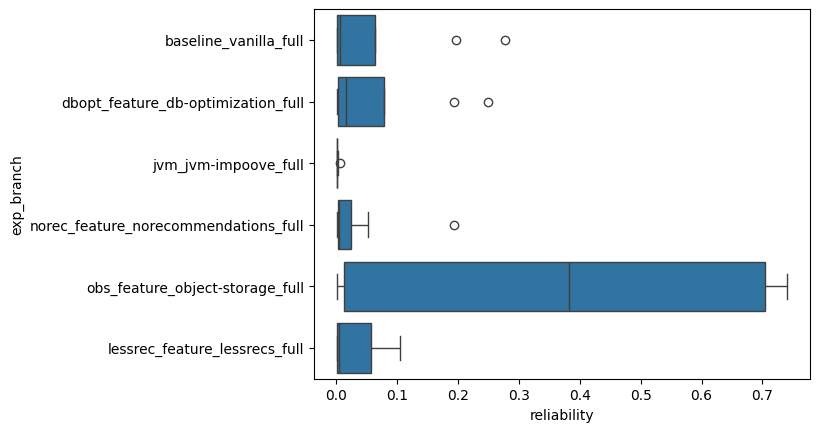

In [94]:

reliability = all_stats.groupby(["exp_time","exp_branch","exp_workload","run"])[["request_count","failure_count"]].sum().reset_index()
reliability["reliability"]=reliability["failure_count"]/reliability["request_count"]

data = reliability
sns.boxplot(data=data,x="reliability",y="exp_branch")

In [95]:
exp_runtime = all_pods.groupby(["exp_run","exp_branch","exp_workload","exp_run_i"])["exp_time"].max().reset_index()

reliability

,exp_time,exp_branch,exp_workload,run,request_count,failure_count,reliability
0,2024-06-21_18-22-58,baseline_vanilla_full,exp_scale_fixed,baseline_vanilla_full_exp_scale_fixed_0,2795,17,0.006082
1,2024-06-21_18-22-58,baseline_vanilla_full,exp_scale_rampup,baseline_vanilla_full_exp_scale_rampup_0,24926,4883,0.195900
2,2024-06-21_18-22-58,baseline_vanilla_full,exp_scale_shaped,baseline_vanilla_full_exp_scale_shaped_0,2907,3,0.001032
3,2024-06-21_18-22-58,dbopt_feature_db-optimization_full,exp_scale_fixed,dbopt_feature_db-optimization_full_exp_scale_f...,2688,10,0.003720
4,2024-06-21_18-22-58,dbopt_feature_db-optimization_full,exp_scale_rampup,dbopt_feature_db-optimization_full_exp_scale_r...,18848,4708,0.249788
5,2024-06-21_18-22-58,dbopt_feature_db-optimization_full,exp_scale_shaped,dbopt_feature_db-optimization_full_exp_scale_s...,2827,3,0.001061
6,2024-06-21_18-22-58,jvm_jvm-impoove_full,exp_scale_fixed,jvm_jvm-impoove_full_exp_scale_fixed_0,2668,1,0.000375
7,2024-06-21_18-22-58,jvm_jvm-impoove_full,exp_scale_rampup,jvm_jvm-impoove_full_exp_scale_rampup_0,74575,27,0.000362
8,2024-06-21_18-22-58,jvm_jvm-impoove_full,exp_scale_shaped,jvm_jvm-impoove_full_exp_scale_shaped_0,2924,1,0.000342
9,2024-06-21_18-22-58,norec_feature_norecommendations_full,exp_scale_fixed,norec_feature_norecommendations_full_exp_scale...,2802,12,0.004283


In [36]:
physical_nodes = ["sm-gpu","ise-knode6"]
model_data = all_nodes[all_nodes["instance"].isin(physical_nodes)].groupby(["collection_time","instance"])[["num_processes","cpu_usage","memory_usage","network_usage","wattage","wattage_kepler","wattage_scaph","wattage_auxilary","wattage_estimation"]].sum()

model_data_pods = all_pods[all_pods["instance"].isin(physical_nodes)].groupby(["collection_time","instance"])[["wattage_kepler","wattage_scaph"]].sum().rename(columns={"wattage_kepler":"wattage_kepler_pods","wattage_scaph":"wattage_scaph_pods"})

model_data = model_data.join(model_data_pods) #model_data.merge(model_data_pods, left_index=True, right_on=["collection_time","instance"])

model_data["wattage_scaph_total"] = model_data["wattage_scaph"]+model_data["wattage_scaph_pods"]+model_data["wattage_auxilary"]
model_data["wattage_kepler_total"] = model_data["wattage_kepler"]+model_data["wattage_kepler_pods"]

In [37]:
model_data[["wattage","num_processes","network_usage","wattage_estimation","cpu_usage","memory_usage","wattage_kepler_total","wattage_scaph_total","wattage_scaph","wattage_kepler","wattage_scaph_pods","wattage_kepler_pods"]].corr()

,wattage,num_processes,network_usage,wattage_estimation,cpu_usage,memory_usage,wattage_kepler_total,wattage_scaph_total,wattage_scaph,wattage_kepler,wattage_scaph_pods,wattage_kepler_pods
wattage,1.000000,-0.500045,0.497656,0.859124,0.664267,0.529976,0.520440,0.630347,0.705676,-0.177558,0.373171,0.519972
num_processes,-0.500045,1.000000,-0.161777,-0.499293,-0.088872,-0.631839,-0.506047,0.049613,-0.315407,0.834237,0.303563,-0.507104
network_usage,0.497656,-0.161777,1.000000,0.613012,0.513413,0.338929,0.399994,0.532087,0.517434,0.066835,0.446108,0.399417
wattage_estimation,0.859124,-0.499293,0.613012,1.000000,0.764837,0.529318,0.586187,0.733260,0.785363,-0.140371,0.427746,0.585618
cpu_usage,0.664267,-0.088872,0.513413,0.764837,1.000000,0.349623,0.187750,0.722934,0.681472,0.318123,0.742280,0.186550
memory_usage,0.529976,-0.631839,0.338929,0.529318,0.349623,1.000000,0.667772,0.152361,0.422430,-0.528136,0.005573,0.667915
wattage_kepler_total,0.520440,-0.506047,0.399994,0.586187,0.187750,0.667772,1.000000,0.443288,0.467732,-0.383910,0.239055,0.999999
wattage_scaph_total,0.630347,0.049613,0.532087,0.733260,0.722934,0.152361,0.443288,1.000000,0.973959,0.427879,0.699406,0.442261
wattage_scaph,0.705676,-0.315407,0.517434,0.785363,0.681472,0.422430,0.467732,0.973959,1.000000,0.070332,0.522768,0.466870
wattage_kepler,-0.177558,0.834237,0.066835,-0.140371,0.318123,-0.528136,-0.383910,0.427879,0.070332,1.000000,0.552201,-0.385373


In [38]:


model_data.reset_index(inplace=True)
for node in physical_nodes:

    y = model_data[model_data["instance"]==node]['wattage'].values
    X = model_data[model_data["instance"]==node][['cpu_usage', 'memory_usage']].values



    # Initial guess for the parameters (intercept and coefficients)
    initial_guess = [30, 1, 1]

    # Use curve_fit to fit the model
    params, covariance = curve_fit(energy_func, X, y, p0=initial_guess)

    # Extract the parameters
    # intercept, coef_cpu, coef_memory, coef_network = params
    display(f"{node} - {params}")

'sm-gpu - [45.0718487  10.40623586 -1.37936596]'

'ise-knode6 - [40.66444374  1.02156944 28.74262563]'

In [39]:
def comparision_plot(data, y_label, exp_branch):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    sns.lineplot(data=data[data["exp_branch"]==exp_branch],x="exp_time",y=y_label,ax=axs[0])
    axs[0].set_title(exp_branch)
    sns.lineplot(data=data[data["exp_branch"]=="baseline_vanilla_full"],x="exp_time",y=y_label,ax=axs[1])
    axs[1].set_title("baseline")
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    

In [41]:
requests = all_stats.groupby(["exp_branch","exp_workload"])[["request_count","failure_count"]].sum()
requests.reset_index(inplace=True)
requests["request_count"] -= requests["failure_count"]
requests

,exp_branch,exp_workload,request_count,failure_count
0,baseline_vanilla_full,exp_scale_fixed,8491,65
1,baseline_vanilla_full,exp_scale_pausing,1993,89
2,baseline_vanilla_full,exp_scale_rampup,56412,16121
3,baseline_vanilla_full,exp_scale_shaped,8531,6
4,dbopt_feature_db-optimization_full,exp_scale_fixed,8349,41
5,dbopt_feature_db-optimization_full,exp_scale_pausing,2118,39
6,dbopt_feature_db-optimization_full,exp_scale_rampup,45018,14139
7,dbopt_feature_db-optimization_full,exp_scale_shaped,7458,81
8,jvm_jvm-impoove_full,exp_scale_fixed,8261,12
9,jvm_jvm-impoove_full,exp_scale_pausing,2314,12


In [42]:
total_pod_wattage = all_pods.groupby(["exp_branch","exp_workload"])[["wattage_kepler","wattage_scaph","exp_time"]].sum().reset_index()
total_pod_wattage["mean_wattage_kepler"]=total_pod_wattage["wattage_kepler"]/total_pod_wattage["exp_time"]
total_pod_wattage["mean_wattage_scaph"]=total_pod_wattage["wattage_scaph"]/total_pod_wattage["exp_time"]

total_pod_wattage = total_pod_wattage[["exp_branch","exp_workload","mean_wattage_kepler","mean_wattage_scaph"]]

In [43]:
experiment_mean_wattage = total_pod_wattage.merge(requests,on=["exp_branch","exp_workload"])
experiment_mean_wattage["total_kepler"] = experiment_mean_wattage["mean_wattage_kepler"] * experiment_mean_wattage["request_count"]
experiment_mean_wattage["total_scaph"] = experiment_mean_wattage["mean_wattage_scaph"] * experiment_mean_wattage["request_count"]
experiment_mean_wattage = experiment_mean_wattage[["exp_branch","exp_workload","total_kepler","total_scaph"]].groupby(["exp_branch"])[["total_kepler","total_scaph"]].sum().reset_index()
display(experiment_mean_wattage)
experiment_mean_wattage[["total_kepler","total_scaph"]] - experiment_mean_wattage[experiment_mean_wattage["exp_branch"]=="baseline_vanilla_full"][["total_kepler","total_scaph"]].values



,exp_branch,total_kepler,total_scaph
0,baseline_vanilla_full,105012.226709,69.493689
1,dbopt_feature_db-optimization_full,88238.267001,85.856048
2,jvm_jvm-impoove_full,367024.696499,5178.788313
3,lessrec_feature_lessrecs_full,120878.266432,547.168929
4,norec_feature_norecommendations_full,225099.552733,207.194779
5,obs_feature_object-storage_full,19912.808496,4.976005


,total_kepler,total_scaph
0,0.000000,0.000000
1,-16773.959707,16.362359
2,262012.469791,5109.294624
3,15866.039724,477.675241
4,120087.326024,137.701090
5,-85099.418213,-64.517683
